# Trialing generative processes for chemical microscopy (part 2)

Last time we used a very rigid generative model (droplets modeled as gaussians). This time we'll use a learned representation of droplets.

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro.distributions as dist
import seaborn as sns
from numpyro import deterministic, plate, sample
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal
from numpyro.optim import Adam
from PIL import Image

plt.rcParams['figure.dpi'] = 200

sns.set_theme(context='paper', style='ticks', font='Arial')

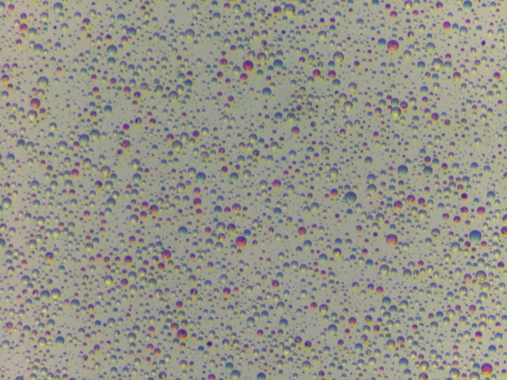

In [2]:
img = Image.open('data/example.jpg')
img = img.resize((img.width // 4, img.height // 4))
img

For simplicity, we'll focus on modeling the H (hue) channel of the image.

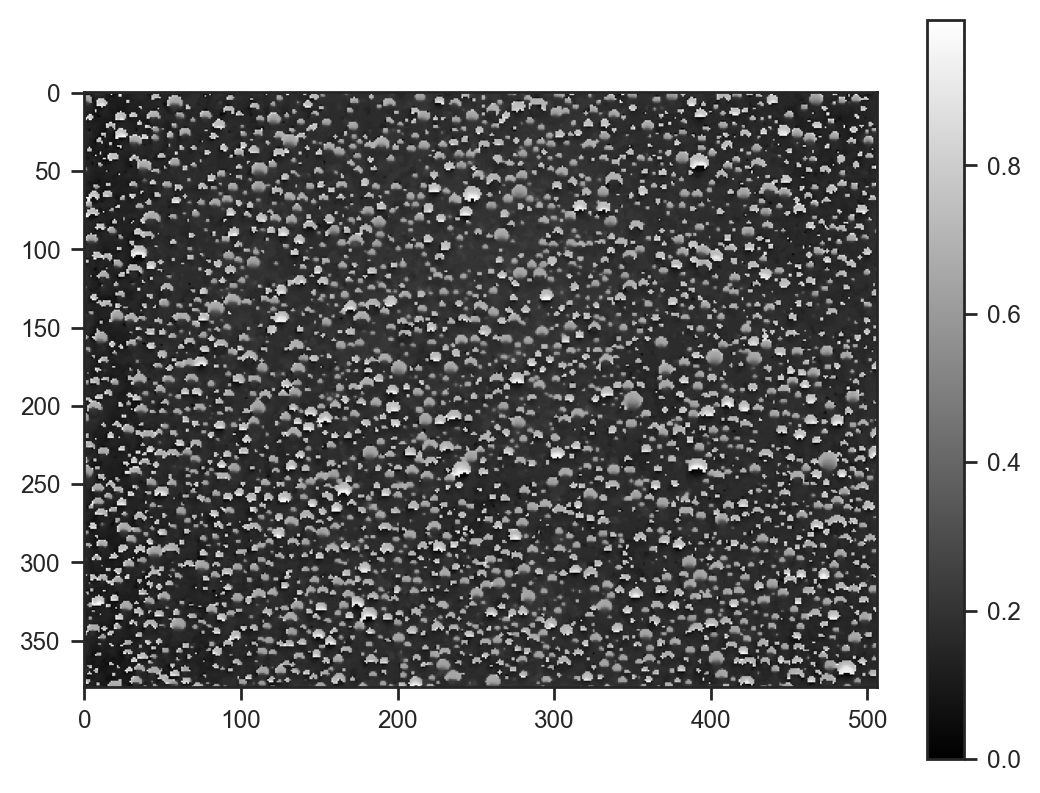

In [3]:
img_hsv = np.array(img.convert('HSV')) / 255.0

plt.imshow(img_hsv[..., 0], cmap='gray')
plt.colorbar()

In [4]:
def model(w, h, n_droplets, channel, types=10, mask_shape=(15, 15)):
    # Sample droplet locations and sizes
    with plate("droplets", n_droplets):
        x = sample("x", dist.Uniform(0, 1)) * (w - mask_shape[1] - 1)
        y = sample("y", dist.Uniform(0, 1)) * (h - mask_shape[0] - 1)
        with plate("types", types):
            composition = sample("composition", dist.Uniform(0, 1))
    mask = sample('mask', dist.Uniform(0, 1).expand((types, *mask_shape)))

    # Instead of round, use floor and linear interpolation
    x_floor = jnp.floor(x)
    y_floor = jnp.floor(y)
    x_frac = x - x_floor
    y_frac = y - y_floor

    dx = jnp.arange(mask_shape[1])[:, None, None]
    dy = jnp.arange(mask_shape[0])[None, :, None]

    # Generate coordinates for bilinear interpolation
    x1 = x_floor[None, None, :].astype(int) + dx
    x2 = x1 + 1
    y1 = y_floor[None, None, :].astype(int) + dy
    y2 = y1 + 1

    # Calculate weights for bilinear interpolation
    wx2 = x_frac[None, None, :]
    wx1 = 1 - wx2
    wy2 = y_frac[None, None, :]
    wy1 = 1 - wy2

    # Calculate droplet masks
    droplet_masks = jnp.einsum('tn,thw->hwn', composition, mask)

    # Initialize background
    bg = sample("bg", dist.Uniform(0, 1))
    img = jnp.full((h, w), bg)

    # Add droplets using bilinear interpolation
    img = img.at[y1, x1].add(droplet_masks * (wx1 * wy1))
    img = img.at[y1, x2].add(droplet_masks * (wx2 * wy1))
    img = img.at[y2, x1].add(droplet_masks * (wx1 * wy2))
    img = img.at[y2, x2].add(droplet_masks * (wx2 * wy2))

    img = jnp.clip(img, 0, 1)
    img = deterministic('img', img)
    diff = deterministic('diff', channel - img)
    sample('obs', dist.Normal(scale=0.05), obs=diff)

100%|██████████| 100000/100000 [01:38<00:00, 1015.79it/s, init loss: 13266128.0000, avg. loss [95001-100000]: 447068.1562]


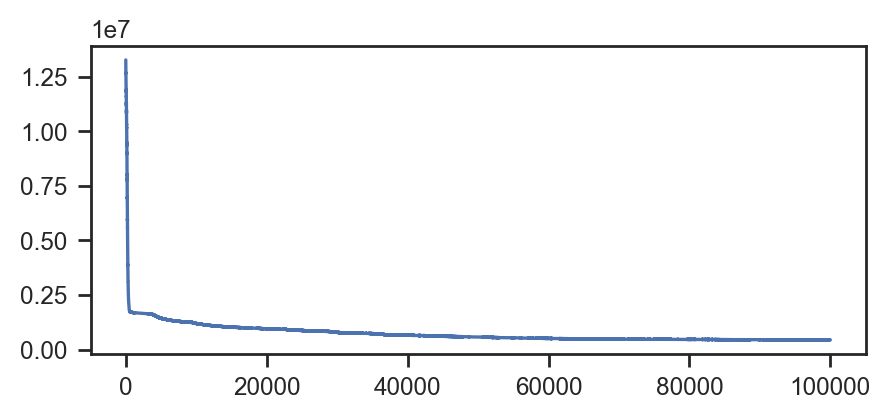

In [9]:
guide = AutoNormal(model)
svi = SVI(model, guide, Adam(0.01), Trace_ELBO())

svi_result = svi.run(jax.random.PRNGKey(0), 100000, img.width, img.height, 2000, img_hsv[..., 0])
samples_svi = guide.sample_posterior(jax.random.PRNGKey(0), svi_result.params, sample_shape=(100,))
fig, ax = plt.subplots(figsize=(5, 2))
ax.plot(svi_result.losses)

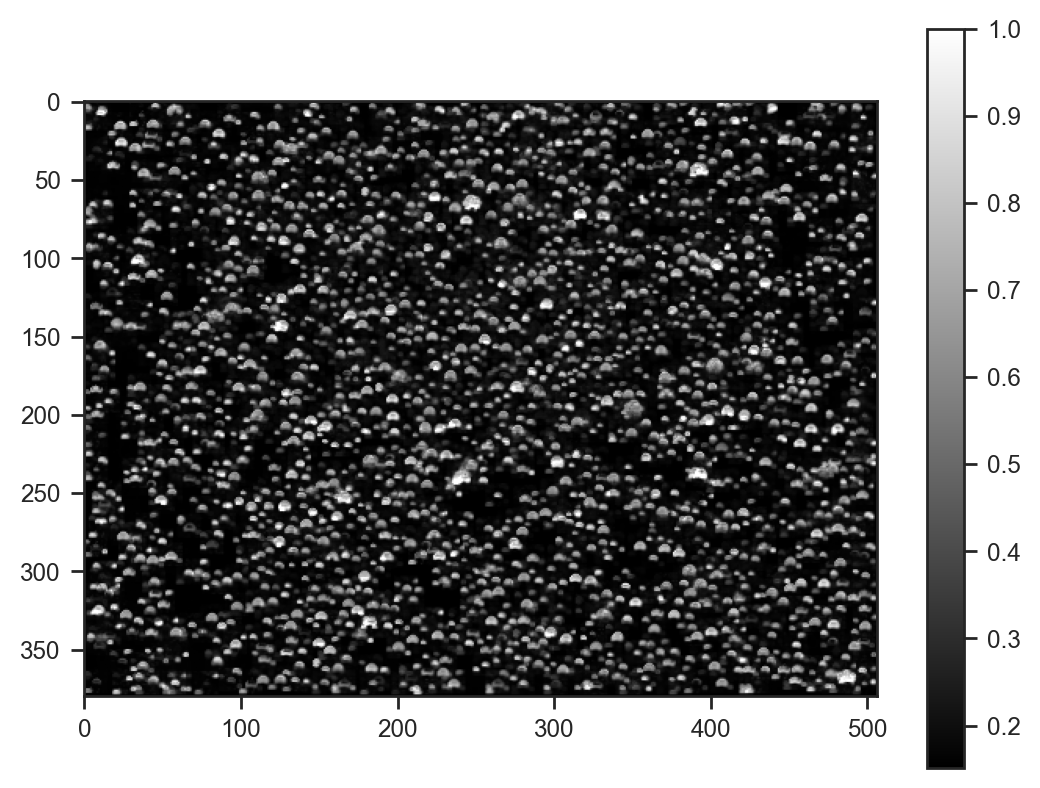

In [11]:
plt.imshow(samples_svi['img'].mean(axis=0), cmap='gray')
plt.colorbar()

Looks quite good!

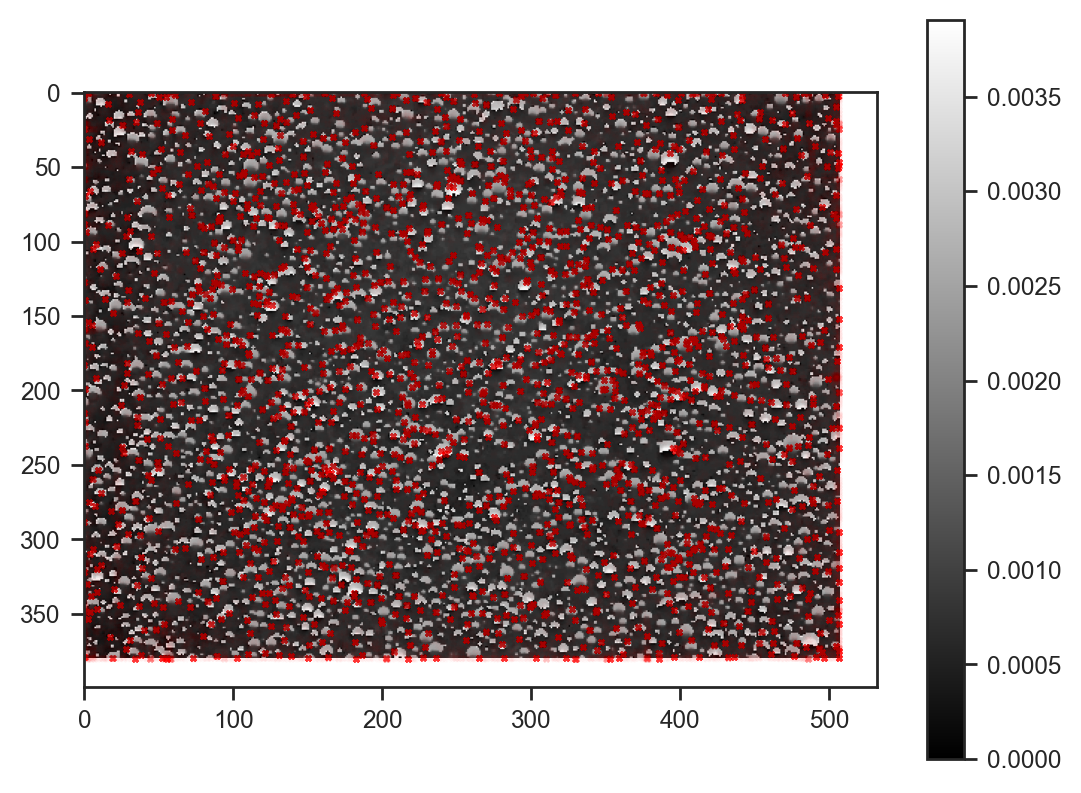

In [12]:
plt.imshow(img_hsv[:, :, 0]/255.0, cmap='gray')
plt.colorbar()
plt.scatter(samples_svi['x'][:100] * img_hsv.shape[1], samples_svi['y'][:100] * img_hsv.shape[0], s=4, alpha=0.01, c='red', marker='x')

Most droplets are now detected — very nice!

Let's have a look at the inferred droplet masks:

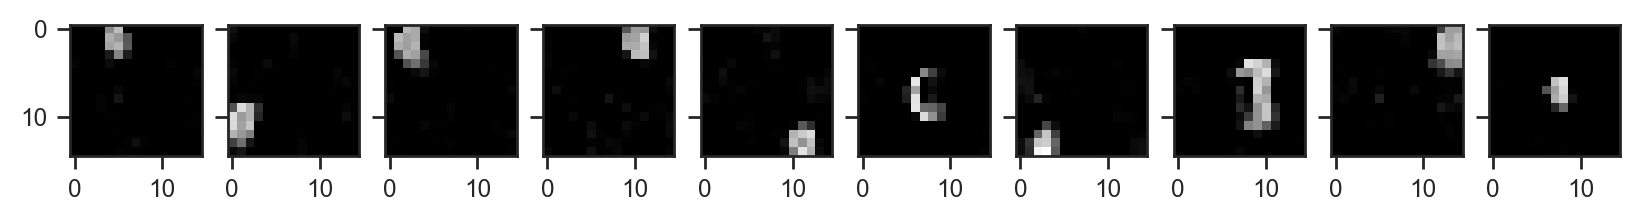

In [13]:
fig, axes = plt.subplots(1, samples_svi['mask'].shape[1], figsize=(samples_svi['mask'].shape[1], 1), sharey=True)
for i, ax in enumerate(axes):
    ax.imshow(samples_svi['mask'].mean(axis=0)[i], cmap='gray', vmin=0, vmax=1)

This model took about 90 seconds to fit on a rusty RTX 2080. Still there is much that could be improved. If new samples include the same droplet types, only at different locations, the masks could be "frozen". Even better, we could use amortised inference for almost instant results. Definitely something to explore in the future.